In [496]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bikeprice/sample_submission.csv
/kaggle/input/bikeprice/train.csv
/kaggle/input/bikeprice/test.csv


# **1. Importing Necessary Libraries**

In [497]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # checking data balancing
import plotly.express as px # Data Visualization
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots # Multiple plots in 1 plot
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# **2. Loading Training Dataset 📊**

In [498]:
train_data = pd.read_csv('../input/bikeprice/train.csv')

# Printing first 10 rows of the dataset
train_data.head(10)

,bike_id,model_name,model_year,kms_driven,owner,location,mileage,power,price
0,0,Bajaj V15 150cc 2017,2017,14000 Km,first owner,faridabad,57 kmpl,11.80 bhp,37000
1,1,Royal Enfield Classic 350cc 2015,2015,25350 Km,first owner,bangalore,35 kmpl,19.80 Bhp,103900
2,2,TVS Apache RTR 160cc 2019,2019,Mileage 60 Kmpl,first owner,etawah,60 Kmpl,15.2 bhp,85000
3,3,Royal Enfield Classic 500cc 2017,2017,14000 Km,first owner,bangalore,35 kmpl,27.20 bhp,140000
4,4,TVS Apache RTR 200 4V FI 2017,2017,Mileage 40 Kmpl,first owner,delhi,40 Kmpl,20.70 bhp,75000
5,5,TVS Apache RTR 200 4V Carburetor 2017,2017,Mileage 40 Kmpl,first owner,noida,40 Kmpl,20.70 bhp,70000
6,6,TVS Apache RR310 Slipper Clutch 2019,2019,5000 Km,first owner,delhi,22 kmpl,33 bhp,185000
7,7,Bajaj Pulsar 220F 2017,2017,20012 Km,first owner,noida,38 kmpl,21 bhp,56000
8,8,Honda CBR 150R 150cc 2017,2017,Mileage 38 Kmpl,first owner,gurgaon,38 Kmpl,18.28 bhp,70000
9,9,Hero Passion 100cc 2001,2001,39000 Km,second owner,dharwad,55 kmpl,7.5 Bhp,33100


***📌 Our Dataset is loaded successfully!***

# **3. Data Preprocessing 🤓**

In [499]:
print('The shape of our training set: %s Bikes and %s input features'%(train_data.shape[0],train_data.shape[1] - 1))
print("\nColumns in our dataset: " , train_data.columns)

The shape of our training set: 5892 Bikes and 8 input features

Columns in our dataset:  Index(['bike_id', 'model_name', 'model_year', 'kms_driven', 'owner',
       'location', 'mileage', 'power', 'price'],
      dtype='object')


***📌 We have 5892 data points and 8 input features.***

In [500]:
print("List of Numerical features: \n" , train_data.select_dtypes(include=np.number).columns.tolist())
print("\n\nList of Categorical features: \n" , train_data.select_dtypes(include=['object']).columns.tolist())

List of Numerical features: 
 ['bike_id', 'model_year', 'price']


List of Categorical features: 
 ['model_name', 'kms_driven', 'owner', 'location', 'mileage', 'power']


In [501]:
train_data.columns

Index(['bike_id', 'model_name', 'model_year', 'kms_driven', 'owner',
       'location', 'mileage', 'power', 'price'],
      dtype='object')

# *3.1 Checking Missing Values*

In [502]:
train_data.isnull().sum()

bike_id        0
model_name     0
model_year     0
kms_driven     0
owner          0
location      13
mileage        9
power         23
price          0
dtype: int64

<AxesSubplot:>

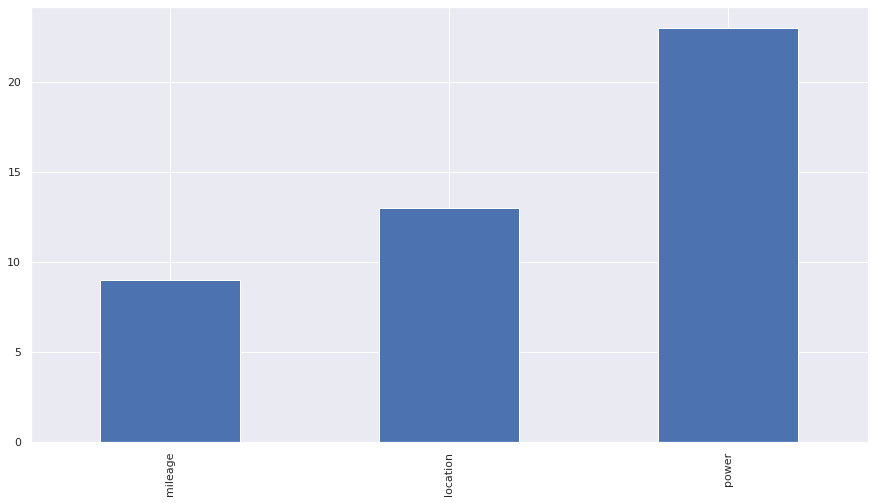

In [503]:
missing = train_data.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
plt.figure(figsize=(15,8))
missing.plot.bar()

# *3.2 Handling Missing Values*

**A. power**

In [504]:
train_data['power'].value_counts()

19.80 bhp          714
13 bhp             259
19 bhp             214
27.20 bhp          211
24.50 bhp          152
                  ... 
159.80 bhp           1
16.3 bhp             1
25.35 bhp            1
29.9 hp / 22 kW      1
47.50 bhp            1
Name: power, Length: 257, dtype: int64

In [505]:
train_data['power'] = train_data['power'].fillna(train_data['power'].mode()[0])
train_data.isnull().sum()

bike_id        0
model_name     0
model_year     0
kms_driven     0
owner          0
location      13
mileage        9
power          0
price          0
dtype: int64

**B. mileage**

In [506]:
train_data['mileage'].value_counts()

 35 kmpl    815
            543
 40 kmpl    481
 65 Kmpl    328
 25 kmpl    246
           ... 
 15 Kmpl      1
 68 Kmpl      1
 70 kmpl      1
 25kmpl       1
 55           1
Name: mileage, Length: 115, dtype: int64

In [507]:
train_data['mileage'] = train_data['mileage'].fillna(train_data['mileage'].mode()[0])
train_data.isnull().sum()

bike_id        0
model_name     0
model_year     0
kms_driven     0
owner          0
location      13
mileage        0
power          0
price          0
dtype: int64

**C. location**

In [508]:
train_data['location'].value_counts()

delhi           1077
mumbai           632
bangalore        590
pune             263
hyderabad        257
                ... 
aonla              1
nabarangapur       1
nalbari            1
deoria             1
dhrangadhra        1
Name: location, Length: 486, dtype: int64

In [509]:
train_data['location'] = train_data['location'].fillna(train_data['location'].mode()[0])
train_data.isnull().sum()

bike_id       0
model_name    0
model_year    0
kms_driven    0
owner         0
location      0
mileage       0
power         0
price         0
dtype: int64

# *3.3 Checking Outliers*

In [510]:
fig = px.box(data_frame = train_data,hover_name = 'bike_id',
             y = 'price', color = 'model_year', width = 800,height = 600, title = 'Box plot of the Bike Price w.r.t. model_year(Hover for details)')
fig.show()

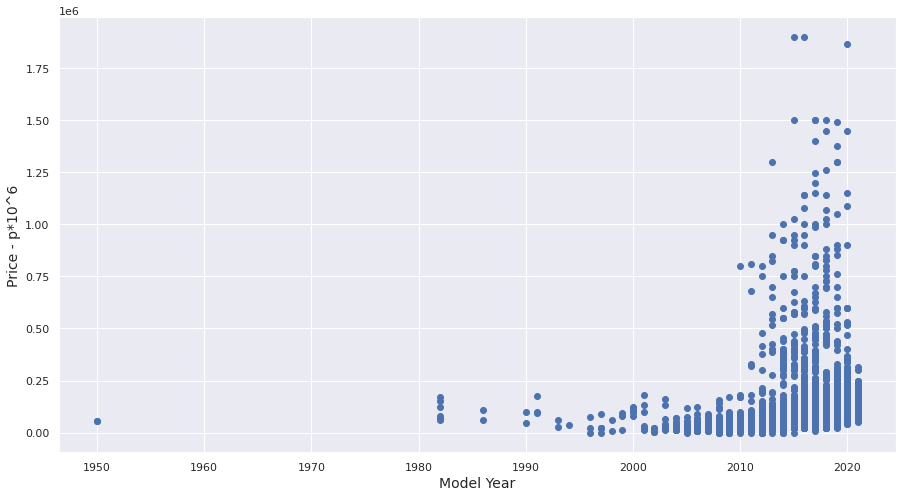

In [511]:
plt.scatter(x='model_year' , y='price', data=train_data)
# plt.scatter(x='model_year' , y='price', data=train_data, c='green', vmin=0, vmax=100, cmap='rainbow')

# Change the X and Y ranges
# plt.xlim( - , - )
# plt.ylim( - , - )

# Add in labels for the axes
plt.ylabel('Price - p*10^6', fontsize=14)
plt.xlabel('Model Year', fontsize=14)

# Make the colorbar show
# plt.colorbar(label='Gamma Ray - API')

plt.show()

<AxesSubplot:xlabel='price', ylabel='Count'>

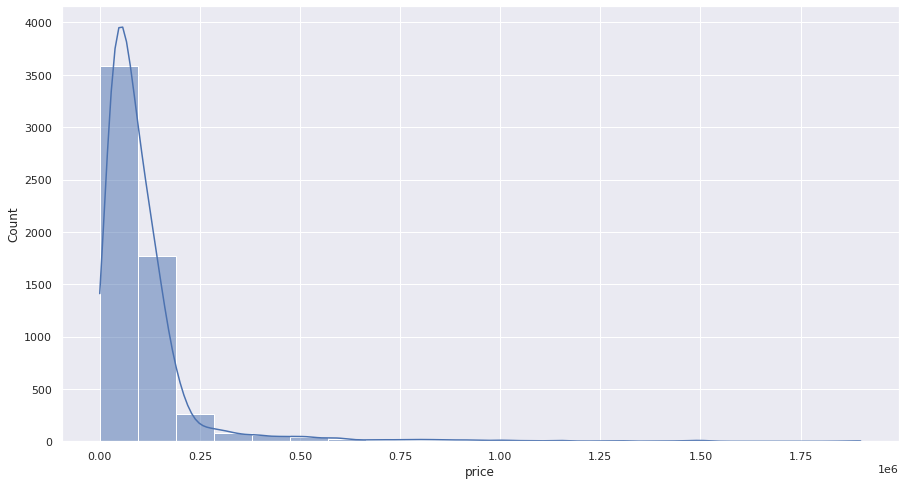

In [512]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(train_data['price'], kde=True, bins=20)

# *Removing Outliers*

**As we can see from the above graphs that there are a lot of outliers so we set a threshold for the *PRICE* and *MODEL_YEAR*. Here I have taken it to be 750000 for PRICE and 1995 for MODEL_YEAR (purely arbitary choice).**

In [513]:
removed = 0
threshold1 = 600000
threshold2 = 2000
for i in train_data.index:
    if (train_data['price'][i]>threshold1) or (train_data['model_year'][i]<threshold2):
        train_data = train_data.drop(i)
        removed+=1
print('Total number of data points removed till now are: '+str(removed))

Total number of data points removed till now are: 118


**Since we do not want to remove too many data ponts, we will keep a track of how many data points have been removed. Here we have removed around 2% of the total dataset which seem like outliers.**# *3.4 Visualising Categorical Features*

# *3.4 Visualising Categorical Features*

**Shows Model Years of the bikes with their respective percentages**

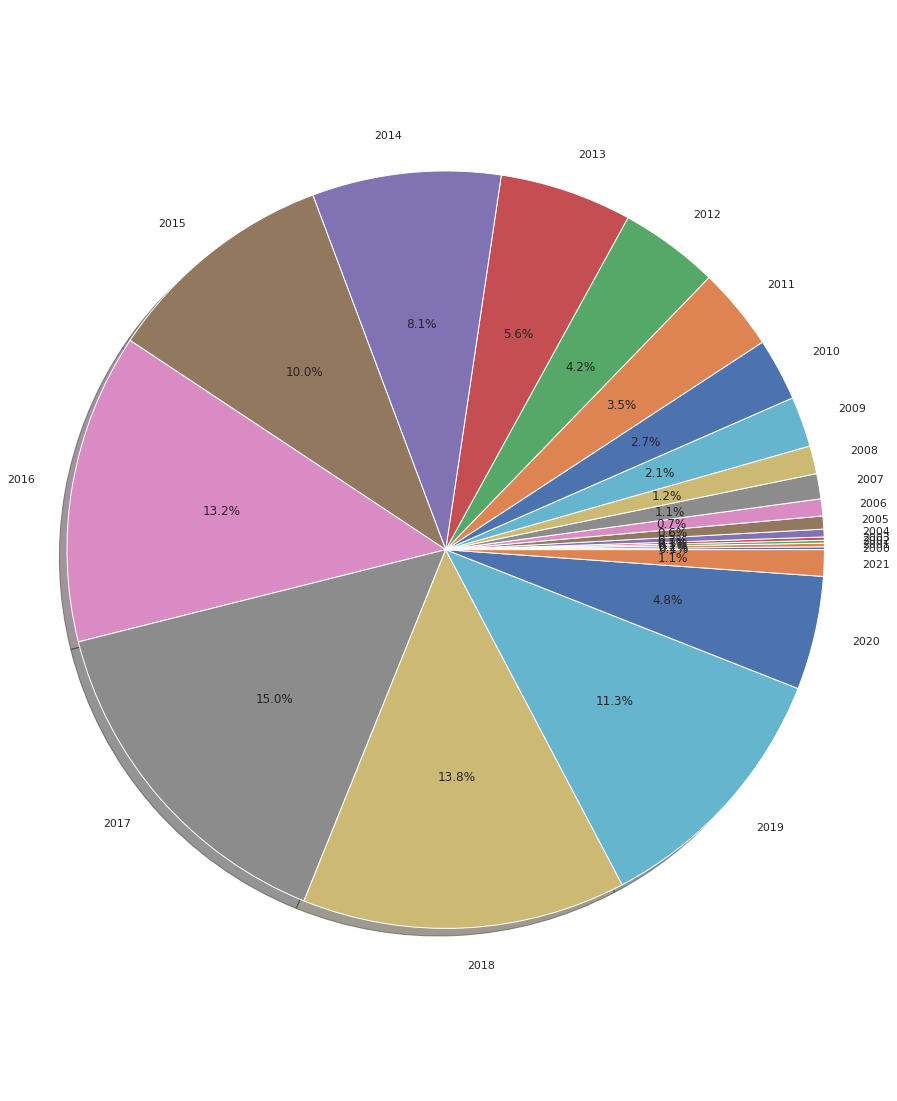

In [514]:
labels = train_data['model_year'].astype('category').cat.categories.tolist()
counts = train_data['model_year'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots(figsize = (15,20))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

**Shows Owners of the bikes with their respective percentages**

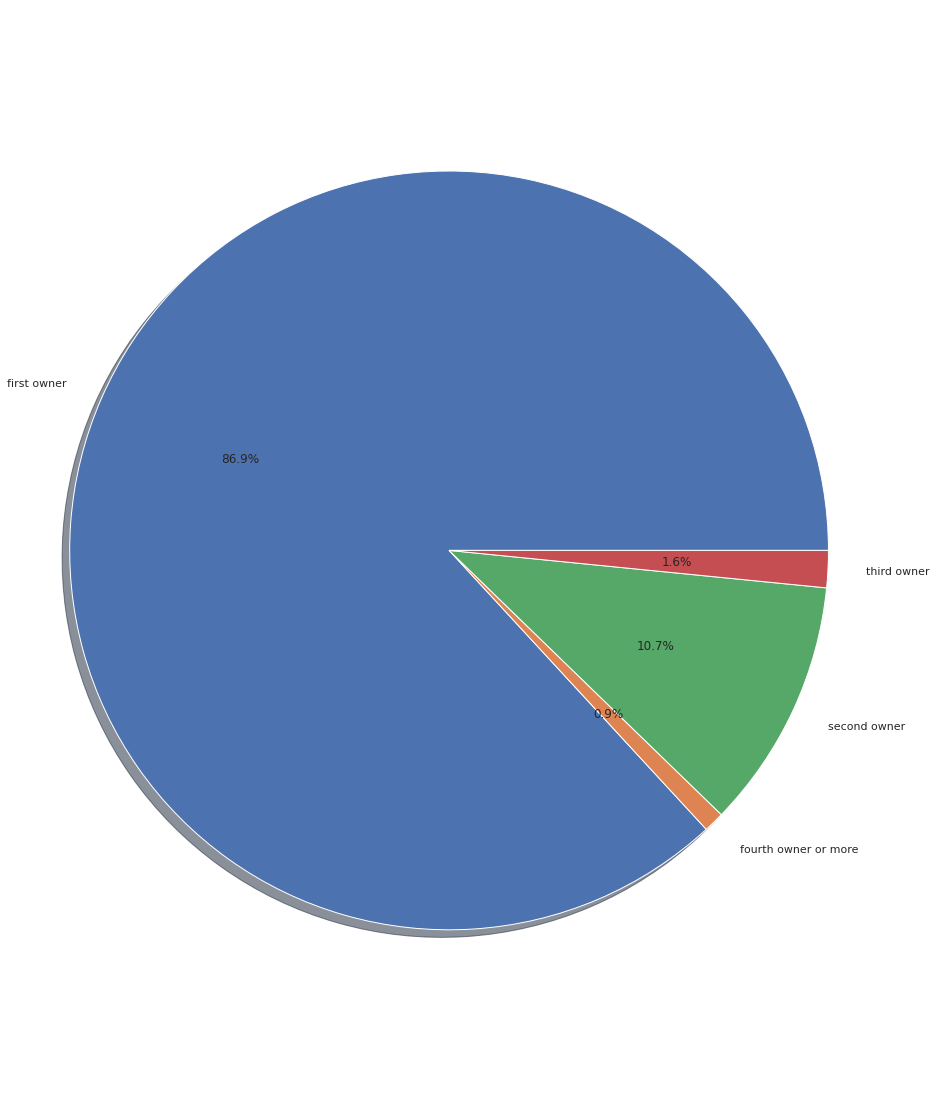

In [515]:
labels = train_data['owner'].astype('category').cat.categories.tolist()
counts = train_data['owner'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots(figsize = (15,20))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

# *3.5 Encoding For Categorical Variables*

In [516]:
categorical_vars = train_data.select_dtypes(include=['object']).columns.tolist()
    
print("\n\nList of Categorical features: \n" , categorical_vars)
print("\n")
for x in categorical_vars:
    print("Distinct Values in " + x + " : " + str(len(pd.unique(train_data[x]))) ) 



List of Categorical features: 
 ['model_name', 'kms_driven', 'owner', 'location', 'mileage', 'power']


Distinct Values in model_name : 1454
Distinct Values in kms_driven : 1446
Distinct Values in owner : 4
Distinct Values in location : 481
Distinct Values in mileage : 103
Distinct Values in power : 220


* Since owner has  have few distinct values we can safely apply dummy variable encoding or One hot encoding.
* model_name, kms_driven, location, mileage and power have so many distinct values hence label encoding can be used.

**3.5.1 Dummy Variable Encoding for owner**

In [517]:
# WE CREATE DUMMY VARIABLES FOR OWNER ATTRIBUTE
# IT WILL ASSIGN 0 AND 1 TO ALL TYPES OF OWNERS
dummies = pd.get_dummies(train_data.owner)

# NOW ADDING DUMMY VARIABLE TO THE TRAIN_DATA
train_data = pd.concat([train_data,dummies], axis='columns')

# NOW AS WE HAVE ADDED THE DUMMY VARIABLE WE CAN REMOVE THE "OWNER" ATTRIBUTE
train_data = train_data.drop(['owner'], axis='columns')
train_data.head(10)

,bike_id,model_name,model_year,kms_driven,location,mileage,power,price,first owner,fourth owner or more,second owner,third owner
0,0,Bajaj V15 150cc 2017,2017,14000 Km,faridabad,57 kmpl,11.80 bhp,37000,1,0,0,0
1,1,Royal Enfield Classic 350cc 2015,2015,25350 Km,bangalore,35 kmpl,19.80 Bhp,103900,1,0,0,0
2,2,TVS Apache RTR 160cc 2019,2019,Mileage 60 Kmpl,etawah,60 Kmpl,15.2 bhp,85000,1,0,0,0
3,3,Royal Enfield Classic 500cc 2017,2017,14000 Km,bangalore,35 kmpl,27.20 bhp,140000,1,0,0,0
4,4,TVS Apache RTR 200 4V FI 2017,2017,Mileage 40 Kmpl,delhi,40 Kmpl,20.70 bhp,75000,1,0,0,0
5,5,TVS Apache RTR 200 4V Carburetor 2017,2017,Mileage 40 Kmpl,noida,40 Kmpl,20.70 bhp,70000,1,0,0,0
6,6,TVS Apache RR310 Slipper Clutch 2019,2019,5000 Km,delhi,22 kmpl,33 bhp,185000,1,0,0,0
7,7,Bajaj Pulsar 220F 2017,2017,20012 Km,noida,38 kmpl,21 bhp,56000,1,0,0,0
8,8,Honda CBR 150R 150cc 2017,2017,Mileage 38 Kmpl,gurgaon,38 Kmpl,18.28 bhp,70000,1,0,0,0
9,9,Hero Passion 100cc 2001,2001,39000 Km,dharwad,55 kmpl,7.5 Bhp,33100,0,0,1,0


**3.5.2 Label Encoding for model_name, kms_driven, location, mileage and power**

*This will assign unique integer values to each of the columns {model_name, kms_driven, location, mileage and power} starting from 0 to the number of unique values - 1*

In [518]:
num = LabelEncoder()

label_col = ['model_name', 'kms_driven', 'location', 'mileage', 'power']

for x in label_col:
    train_data[x] = num.fit_transform(train_data[x].astype(str))
  
train_data.head(10)

,bike_id,model_name,model_year,kms_driven,location,mileage,power,price,first owner,fourth owner or more,second owner,third owner
0,0,297,2017,181,152,67,16,37000,1,0,0,0
1,1,951,2015,637,52,29,87,103900,1,0,0,0
2,2,1204,2019,1433,151,71,52,85000,1,0,0,0
3,3,982,2017,181,52,29,133,140000,1,0,0,0
4,4,1246,2017,1424,135,37,97,75000,1,0,0,0
5,5,1235,2017,1424,343,37,97,70000,1,0,0,0
6,6,1175,2019,1081,135,10,143,185000,1,0,0,0
7,7,229,2017,445,343,33,99,56000,1,0,0,0
8,8,704,2017,1422,181,32,78,70000,1,0,0,0
9,9,464,2001,947,139,63,175,33100,0,0,1,0


# **4. Exploratory Data Analysis 📉**

**We find the correlation of all attributes with the target attribute ie. "price"**

In [519]:
corr = train_data.corr()
print(corr['price'].sort_values(ascending=False), '\n')

price                   1.000000
model_year              0.387101
power                   0.268071
model_name              0.157069
location                0.058901
first owner             0.057417
bike_id                 0.004264
third owner            -0.015355
second owner           -0.041907
fourth owner or more   -0.048541
kms_driven             -0.184554
mileage                -0.536416
Name: price, dtype: float64 



**As we can observe the attributes "bike_id" and "third_owner" are having very low correlation with target variable. So we can remove them to improve oyr model.**

Text(0.5, 1.0, 'Multi-Collinearity of Features')

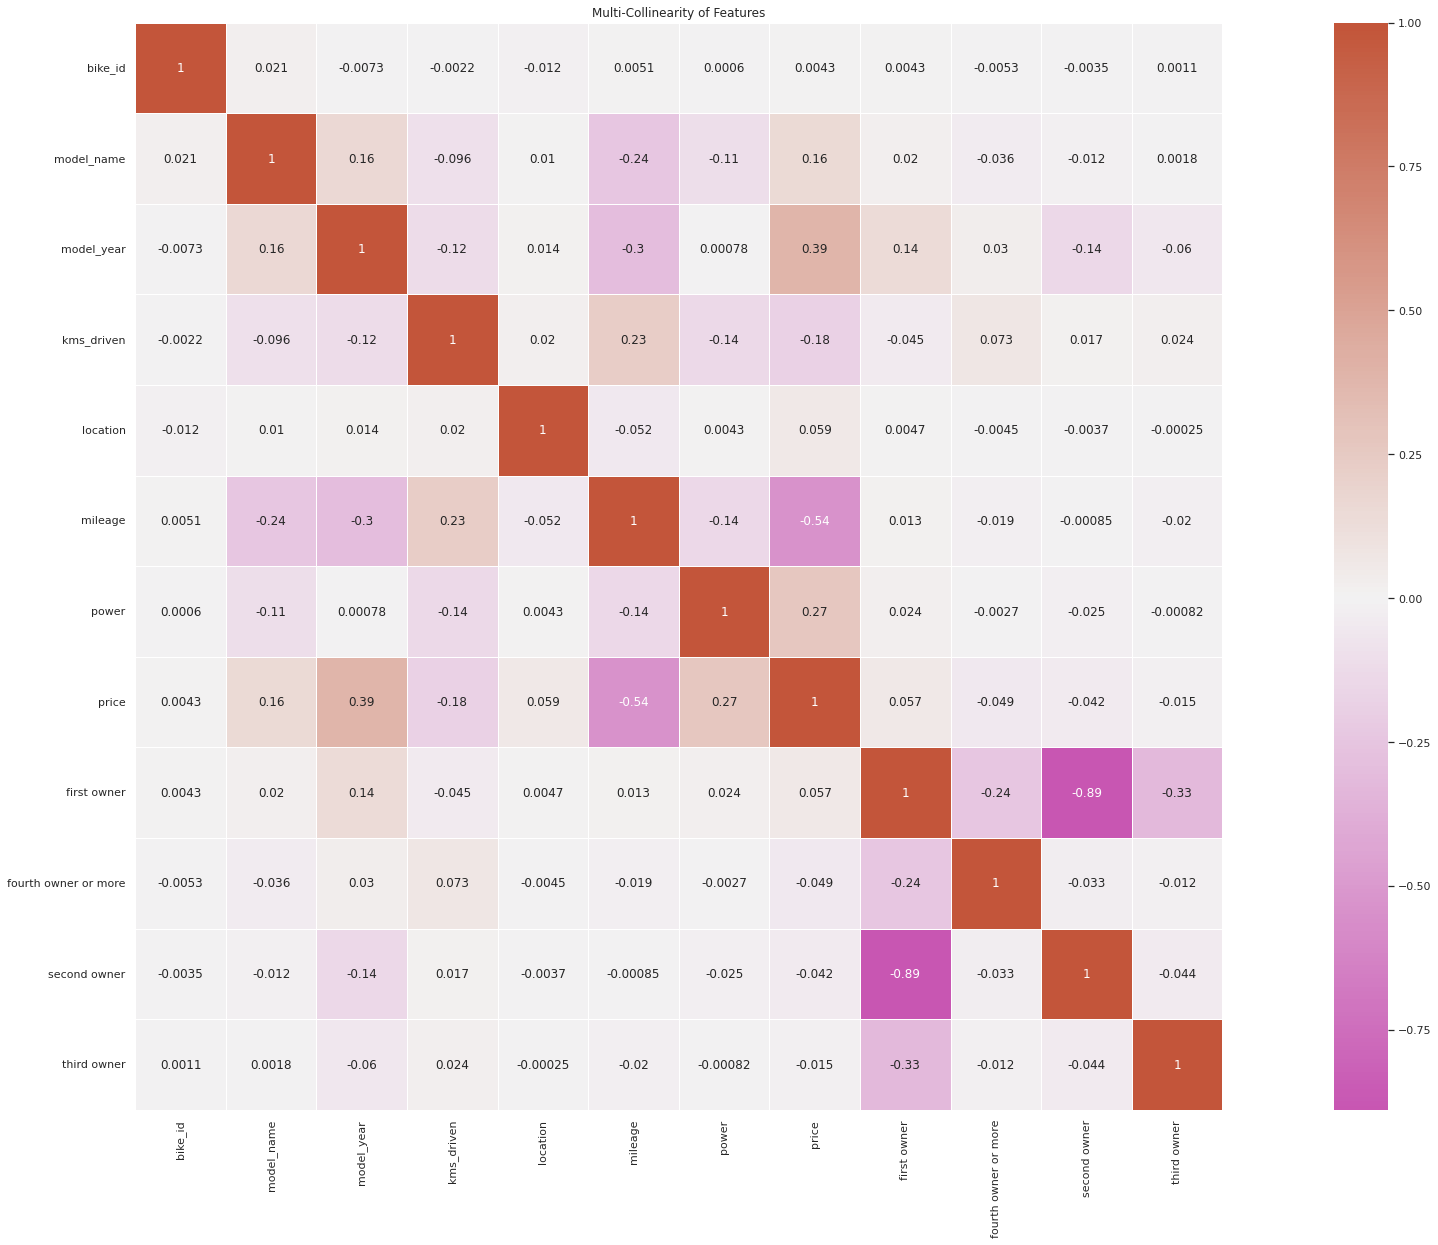

In [520]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(320,20,as_cmap=True)
# Create a covariance matrix
corr = train_data.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40,20))
# Draw the heatmap
sns.heatmap(corr, vmax=1,center=0, square=True, linewidth=1, linecolor='white', 
            annot=True, cmap=cmap)
ax.set_title('Multi-Collinearity of Features')

**📌 Observations:**

1. bike_id is not corelated to any feature, it's just an identification number so we will remove it.
2. price and model_year are positvely correlated (0.39) which is obvious because cars become costly year by year.
3. There is a negative correlation between kms_driven and model_year (-0.12). The reason behind this could be that old cars must be travelled more than new cars.
4. There is a negative correlation between mileage and model_year (-0.3). The reason behind this could be that old cars must be travelled more which results in decreased mileage.
5. There's a negative correlation between first_owner and second_owner (-0.89) because the entries having 1 in preowner_1st_owner must have a 0 in preowner_2nd_owner.
6. No need to feed bike_id and third_owner as they are very loosely correalted to the target attribute ie. price.

# **5. Building Machine Learning Model  🤖**

In [521]:
print("\nColumns in our dataset: " , train_data.columns)


Columns in our dataset:  Index(['bike_id', 'model_name', 'model_year', 'kms_driven', 'location',
       'mileage', 'power', 'price', 'first owner', 'fourth owner or more',
       'second owner', 'third owner'],
      dtype='object')


In [522]:
feed = train_data[['model_name', 'model_year', 'kms_driven', 'location',
                   'mileage', 'power', 'price', 'first owner', 'fourth owner or more',
                   'second owner']]

# Taking all independent variable columns
df_train_x = feed.drop('price',axis = 1)

# Target variable column
df_train_y = feed['price']

# Splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_train_x, df_train_y, test_size=0.25, random_state=42)

**XG Boost Regressor**

In [523]:
xg = xgb.XGBRegressor()
xg.fit(x_train, y_train)
predictions_xg = xg.predict(x_test)
predictions_xg = [max(0,x) for x in predictions_xg]

print("The Root Mean Square Log Error{RMSLE} obtained is:",
      np.sqrt(mean_squared_log_error(y_test, predictions_xg)))

The Root Mean Square Log Error{RMSLE} obtained is: 0.5335747333122401


# **6. Loading Testing Dataset 📊**

In [524]:
test_data = pd.read_csv('../input/bikeprice/test.csv')

# Printing first 10 rows of the dataset
# test_data.head(10)

# test_data.isnull().sum()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   bike_id     1965 non-null   int64 
 1   model_name  1965 non-null   object
 2   model_year  1965 non-null   int64 
 3   kms_driven  1965 non-null   object
 4   owner       1965 non-null   object
 5   location    1959 non-null   object
 6   mileage     1963 non-null   object
 7   power       1957 non-null   object
dtypes: int64(2), object(6)
memory usage: 122.9+ KB


# **7. Applying all Data Preprocessing over Test Dataset**

# *Handling Missing Values*

In [525]:
test_data.isnull().sum()

bike_id       0
model_name    0
model_year    0
kms_driven    0
owner         0
location      6
mileage       2
power         8
dtype: int64

**We have a total of 16 missing values in the same columns as we had in the training set.**

In [526]:
test_data['power'] = test_data['power'].fillna(test_data['power'].mode()[0])
test_data.isnull().sum()

bike_id       0
model_name    0
model_year    0
kms_driven    0
owner         0
location      6
mileage       2
power         0
dtype: int64

In [527]:
test_data['mileage'] = test_data['mileage'].fillna(test_data['mileage'].mode()[0])
test_data.isnull().sum()

bike_id       0
model_name    0
model_year    0
kms_driven    0
owner         0
location      6
mileage       0
power         0
dtype: int64

In [528]:
test_data['location'] = test_data['location'].fillna(test_data['location'].mode()[0])
test_data.isnull().sum()

bike_id       0
model_name    0
model_year    0
kms_driven    0
owner         0
location      0
mileage       0
power         0
dtype: int64

# *Categorical Variable Encodings*

**Dummy Encoding for owner**

In [529]:
# WE CREATE DUMMY VARIABLES FOR OWNER ATTRIBUTE
# IT WILL ASSIGN 0 AND 1 TO ALL TYPES OF OWNERS
dum = pd.get_dummies(test_data.owner)

# NOW ADDING DUMMY VARIABLE TO THE TRAIN_DATA
test_data = pd.concat([test_data,dum], axis='columns')

# NOW AS WE HAVE ADDED THE DUMMY VARIABLE WE CAN REMOVE THE "OWNER" ATTRIBUTE
test_data = test_data.drop(['owner'], axis='columns')
test_data.head(10)

,bike_id,model_name,model_year,kms_driven,location,mileage,power,first owner,fourth owner or more,second owner,third owner
0,0,Royal Enfield Thunderbird X 350cc ABS 2019,2019,10500 Km,delhi,,19.80 bhp,1,0,0,0
1,1,Bajaj Pulsar 180cc 2010,2010,25000 Km,bangalore,65 kmpl,15 bhp,1,0,0,0
2,2,Bajaj Avenger 180cc 2006,2006,57500 Km,bangalore,40 kmpl,19 bhp,1,0,0,0
3,3,Yamaha YZF-R15 V3 150CC ABS 2019,2019,7000 Km,sikar,,18.70 bhp,1,0,0,0
4,4,Suzuki Gixxer 150cc SP Rear Disc 2018,2018,5300 Km,indore,63kmpl,14 bhp,1,0,0,0
5,5,Royal Enfield Thunderbird 350cc 2018,2018,15917 Km,mumbai,40 kmpl,19.80 bhp,1,0,0,0
6,6,Royal Enfield Classic 350cc 2015,2015,16500 Km,pune,35 kmpl,19.80 Bhp,1,0,0,0
7,7,Hero HF Deluxe Kick Alloy 100cc 2018,2018,11000 Km,gurgaon,55 kmpl,6.15kW (8.36 Ps),1,0,0,0
8,8,Bajaj V15 150cc 2017,2017,4000 Km,delhi,57 kmpl,11.80 bhp,1,0,0,0
9,9,Bajaj Pulsar 220F 2016,2016,35000 Km,jaipur,38 kmpl,21 bhp,0,0,1,0


**Label Encoding for model_name, kms_driven, location, mileage and power**

In [530]:
nums = LabelEncoder()

label_col = ['model_name', 'kms_driven', 'location', 'mileage', 'power']

for x in label_col:
    test_data[x] = nums.fit_transform(test_data[x].astype(str))
  
test_data.head(10)

,bike_id,model_name,model_year,kms_driven,location,mileage,power,first owner,fourth owner or more,second owner,third owner
0,0,664,2019,17,75,0,82,1,0,0,0
1,1,129,2010,235,30,73,47,1,0,0,0
2,2,5,2006,440,30,36,78,1,0,0,0
3,3,890,2019,481,231,0,75,1,0,0,0
4,4,683,2018,422,113,70,35,1,0,0,0
5,5,653,2018,100,176,36,82,1,0,0,0
6,6,562,2015,110,201,28,81,1,0,0,0
7,7,263,2018,24,99,58,139,1,0,0,0
8,8,204,2017,350,75,61,13,1,0,0,0
9,9,152,2016,319,116,32,93,0,0,1,0


# **8. Predicting Over Test Dataset 📊**

In [531]:
df_test = test_data.drop(['bike_id', 'third owner'], axis=1)
df_test

,model_name,model_year,kms_driven,location,mileage,power,first owner,fourth owner or more,second owner
0,664,2019,17,75,0,82,1,0,0
1,129,2010,235,30,73,47,1,0,0
2,5,2006,440,30,36,78,1,0,0
3,890,2019,481,231,0,75,1,0,0
4,683,2018,422,113,70,35,1,0,0
...,...,...,...,...,...,...,...,...,...
1960,502,2020,449,7,28,104,1,0,0
1961,378,2015,121,75,7,69,1,0,0
1962,468,2020,285,92,0,121,1,0,0
1963,67,2010,421,5,73,182,1,0,0


In [532]:
test_data_predictions = xg.predict(df_test)
test_data['price'] = test_data_predictions
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965 entries, 0 to 1964
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bike_id               1965 non-null   int64  
 1   model_name            1965 non-null   int64  
 2   model_year            1965 non-null   int64  
 3   kms_driven            1965 non-null   int64  
 4   location              1965 non-null   int64  
 5   mileage               1965 non-null   int64  
 6   power                 1965 non-null   int64  
 7   first owner           1965 non-null   uint8  
 8   fourth owner or more  1965 non-null   uint8  
 9   second owner          1965 non-null   uint8  
 10  third owner           1965 non-null   uint8  
 11  price                 1965 non-null   float32
dtypes: float32(1), int64(7), uint8(4)
memory usage: 122.9 KB


In [533]:
data = test_data[['bike_id', 'price']]
data.to_csv('submission.csv',index=False)

In [534]:
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = data

# create a link to download the dataframe
create_download_link(df)